Linear (ridge) regression to predict streamflow. Target streamflow data is divided by 24 to match hourly forcing resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
from src import load_data, evaluate
from joblib import Parallel, delayed

np.random.seed(0)

In [2]:
station_data_dict = load_data.load_train_test_gridded_dividedStreamflow()

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7 * 24
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history // 24 + 1)
use_runoff_history = False

def train_predict(station):
    station_data = station_data_dict[station]
    station_train = station_data.loc[train_start : '2012-12-31']
    station_test = station_data.loc['2013-01-01' : '2014-12-31']
    print('Fitting model for', station)
    m = linear_model.Ridge(alpha=.5, random_state=123)
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        return (station, None, None)
        
    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    if use_runoff_history:
        for i in range(history):
            for j in range(i + 1, history + 1):
                predict.iloc[i]['runoff_-{}'.format(j)] = station_test.iloc[i]['runoff_-{}'.format(j)]
    print('Predicting', station)
    if not use_runoff_history:
        predict['runoff'] = m.predict(predict.drop('runoff', axis=1))
    else:
        for i in range(len(predict)):
            predict.iloc[i]['runoff'] = m.predict([predict.iloc[i].drop('runoff')])[0]
            for j in range(1, history + 1):
                if (i + j) >= len(predict):
                    break
                predict.iloc[i + j]['runoff_-{}'.format(j)] = predict.iloc[i]['runoff']
    
    return (station, predict[['runoff']], station_test['runoff'])

In [5]:
result_list = Parallel(n_jobs=-1)(delayed(train_predict)(station) for station in list(station_data_dict.keys())[:3])

02GA010 	NSE: clipped before aggregating: 0.17445697760363987 	clipped after aggregating: 0.16788498296550625
02GA018 	NSE: clipped before aggregating: 0.2416179686253883 	clipped after aggregating: 0.2371238267549175
02GA038 	NSE: clipped before aggregating: 0.20180724346464218 	clipped after aggregating: 0.1973443624004283
Median NSE (clipped before aggregating) 0.20180724346464218 / Min 0.17445697760363987 / Max 0.2371238267549175
Median NSE (clipped after aggregating) 0.1973443624004283 / Min 0.16788498296550625 / Max 0.2371238267549175


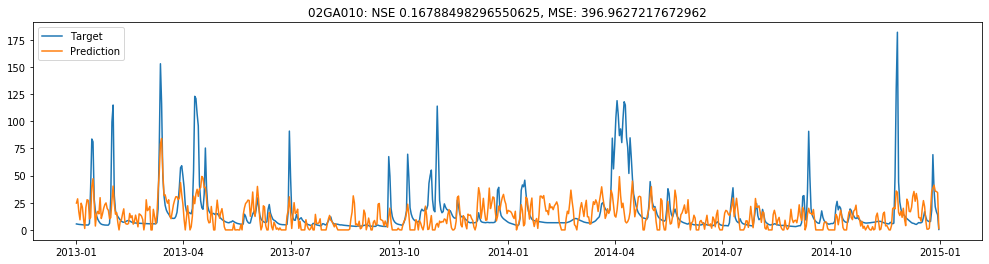

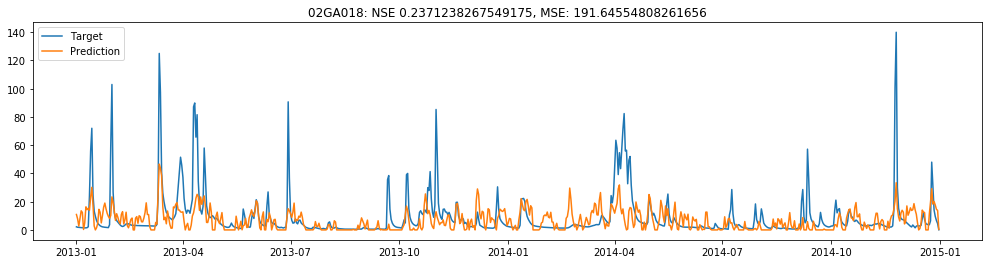

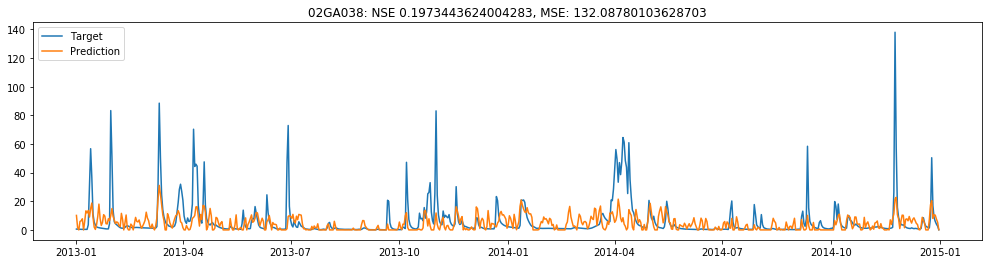

In [7]:
# Evaluate each station
nse_list_clipped_before = []
nse_list_clipped_after = []
#plot_list = ['04159492', '04200500']
for result in result_list:
    station, predict, actual = result
    if predict is None:
        print(station, '\tskipped')
        continue
    nses = evaluate.evaluate_hourly(station, predict['runoff'], actual, plot=True)
    nse_list_clipped_before.append(nses[0][0])
    nse_list_clipped_after.append(nses[1][0])
    
    print(station, '\tNSE: clipped before aggregating:', nse_list_clipped_before[-1], 
          '\tclipped after aggregating:', nse_list_clipped_after[-1])
    
print('Median NSE (clipped before aggregating)', np.median(nse_list_clipped_before), '/ Min', np.min(nse_list_clipped_before), '/ Max', np.max(nse_list_clipped_after))
print('Median NSE (clipped after aggregating)', np.median(nse_list_clipped_after), '/ Min', np.min(nse_list_clipped_after), '/ Max', np.max(nse_list_clipped_after))

In [ ]:
load_data.pickle_results('LinReg_VIC_divideStreamflow', result_list)